## SegNet Segmentation Modelling
### Grayscale Image

In [1]:
import os
import random
from sklearn.model_selection import train_test_split
import shutil
from shutil import copyfile
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, GlobalAveragePooling2D, Dense
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from PIL import Image
from keras.layers import Reshape
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# Dice coefficient function
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)

    y_true_flat = K.reshape(y_true_flat, K.shape(y_true))
    y_pred_flat = K.reshape(y_pred_flat, K.shape(y_pred))

    intersection = K.sum(y_true_flat * y_pred_flat)
    dice = (2.0 * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)
    return dice

# Dice loss function
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

# Intersection over Union (IoU) function
def iou(y_true, y_pred):
    y_true_shape = K.shape(y_true)
    y_pred_shape = K.shape(y_pred)

    if len(y_true_shape) == len(y_pred_shape):
        # Both tensors have the same number of dimensions
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
        union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    else:
        # One of the tensors has a different number of dimensions
        intersection = K.sum(K.abs(y_true * y_pred))
        union = K.sum(y_true) + K.sum(y_pred) - intersection

    iou = K.mean((intersection + 1e-15) / (union + 1e-15))
    return iou

In [3]:
def segnet(input_shape):
    # Encoder
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [4]:
input_shape = (256, 256, 1)
model = segnet(input_shape)

# model compile
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient, iou])

In [5]:
model.input

<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'input_1')>

In [6]:
model.output

<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'conv2d_6')>

In [7]:
# Set the number of epochs and batch size for training
epochs = 30
batch_size = 4

output_folder = r'C:\Users\BoonJane\Desktop\oralcancer\outputgray'

# Set the paths to the train, test, and validation data folders
train_data_dir = os.path.join(output_folder, 'train')
test_data_dir = os.path.join(output_folder, 'test')
val_data_dir = os.path.join(output_folder, 'val')

data_gen = ImageDataGenerator(rescale=1./255)

# Create the data generators for training, validation, and testing
train_data_gen = data_gen.flow_from_directory(
    train_data_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='input',
    seed=42
)

val_data_gen = data_gen.flow_from_directory(
    val_data_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='input',
    seed=42
)

test_data_gen = data_gen.flow_from_directory(
    test_data_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='input',
    seed=42
)

# Evaluate the model on the test dataset
for x, y_true in test_data_gen:
    y_pred = model.predict(x)
    break

Found 1056 images belonging to 4 classes.
Found 88 images belonging to 4 classes.
Found 88 images belonging to 4 classes.
1/1 [==============================] - 0s 423ms/step


In [8]:
# check the shapes
print("Label data shape:", y_true.shape)
print("Predicted data shape:", y_pred.shape)

# check on data because IoU value is not logical
min_value_true = np.min(y_true)
max_value_true = np.max(y_true)
min_value_pred = np.min(y_pred)
max_value_pred = np.max(y_pred)

print("Min value of y_true:", min_value_true)
print("Max value of y_true:", max_value_true)
print("Min value of y_pred:", min_value_pred)
print("Max value of y_pred:", max_value_pred)

# # print y_true and y_predict
# print("y_true:", y_true)
# print("y_pred:", y_pred)

# check data type (need to be float)
print("Data type of y_true:", y_true.dtype)
print("Data type of y_pred:", y_pred.dtype)

Label data shape: (4, 256, 256, 1)
Predicted data shape: (4, 256, 256, 1)
Min value of y_true: 0.0
Max value of y_true: 1.0
Min value of y_pred: 0.49691764
Max value of y_pred: 0.50457174
Data type of y_true: float32
Data type of y_pred: float32


In [9]:
checkpoint_path = "segnetgray_weights.h5"

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss', 
    verbose=1,  
    save_best_only=True,  
    save_weights_only=True  
)

# Train the model
history = model.fit(
    train_data_gen,
    steps_per_epoch=len(train_data_gen),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=len(val_data_gen),
    callbacks=[checkpoint],
)

Epoch 1/30
264/264 [==============================] - ETA: 0s - loss: 0.2736 - dice_coefficient: 0.7264 - iou: 0.6511
Epoch 1: val_loss improved from inf to 0.22794, saving model to segnetgray_weights.h5
264/264 [==============================] - 349s 1s/step - loss: 0.2736 - dice_coefficient: 0.7264 - iou: 0.6511 - val_loss: 0.2279 - val_dice_coefficient: 0.7721 - val_iou: 0.7067
Epoch 2/30
264/264 [==============================] - ETA: 0s - loss: 0.2227 - dice_coefficient: 0.7773 - iou: 0.7256
Epoch 2: val_loss improved from 0.22794 to 0.21187, saving model to segnetgray_weights.h5
264/264 [==============================] - 353s 1s/step - loss: 0.2227 - dice_coefficient: 0.7773 - iou: 0.7256 - val_loss: 0.2119 - val_dice_coefficient: 0.7881 - val_iou: 0.7198
Epoch 3/30
264/264 [==============================] - ETA: 0s - loss: 0.2219 - dice_coefficient: 0.7781 - iou: 0.7327
Epoch 3: val_loss improved from 0.21187 to 0.20698, saving model to segnetgray_weights.h5
264/264 [===========

Epoch 24/30
264/264 [==============================] - ETA: 0s - loss: 0.2166 - dice_coefficient: 0.7834 - iou: 0.7456
Epoch 24: val_loss did not improve from 0.19753
264/264 [==============================] - 346s 1s/step - loss: 0.2166 - dice_coefficient: 0.7834 - iou: 0.7456 - val_loss: 0.2154 - val_dice_coefficient: 0.7846 - val_iou: 0.7456
Epoch 25/30
264/264 [==============================] - ETA: 0s - loss: 0.2157 - dice_coefficient: 0.7843 - iou: 0.7449
Epoch 25: val_loss improved from 0.19753 to 0.19710, saving model to segnetgray_weights.h5
264/264 [==============================] - 349s 1s/step - loss: 0.2157 - dice_coefficient: 0.7843 - iou: 0.7449 - val_loss: 0.1971 - val_dice_coefficient: 0.8029 - val_iou: 0.7537
Epoch 26/30
264/264 [==============================] - ETA: 0s - loss: 0.2123 - dice_coefficient: 0.7877 - iou: 0.7448
Epoch 26: val_loss did not improve from 0.19710
264/264 [==============================] - 347s 1s/step - loss: 0.2123 - dice_coefficient: 0.787

In [10]:
# Evaluate the model on the validation dataset
validation_loss, validation_dice_coefficient, validation_iou = model.evaluate(val_data_gen, steps=len(val_data_gen))
print("Validation Loss:", validation_loss)
print("Validation Dice Coefficient:", validation_dice_coefficient)
print("Validation IoU:", validation_iou)

22/22 [==============================] - 7s 319ms/step - loss: 0.2115 - dice_coefficient: 0.7885 - iou: 0.7498
Validation Loss: 0.21151547133922577
Validation Dice Coefficient: 0.788484513759613
Validation IoU: 0.749751627445221


In [11]:
# Test the model on the test dataset
test_loss, test_dice_coefficient, test_iou = model.evaluate(test_data_gen, steps=len(test_data_gen))
print("Test Loss:", test_loss)
print("Test Dice Coefficient:", test_dice_coefficient)
print("Test IoU:", test_iou)

22/22 [==============================] - 7s 319ms/step - loss: 0.2132 - dice_coefficient: 0.7868 - iou: 0.7507
Test Loss: 0.21324467658996582
Test Dice Coefficient: 0.7867553234100342
Test IoU: 0.7506637573242188


In [12]:
# Use the model for predictions
predictions = model.predict(test_data_gen)
# 'predictions' is an array containing the predicted masks for the test images

# Save the predicted masks as images
output_folder = r"C:\Users\BoonJane\Desktop\oralcancer\segnet\predictionsgray"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for i, (x, _) in enumerate(test_data_gen):
    # Generate predictions for batch of images
    y_pred = model.predict(x)

    # Save each predicted mask as an image
    for j in range(len(y_pred)):
        mask = y_pred[j] > 0.5  # Threshold predicted mask
        mask_img = array_to_img(mask)
        mask_img.save(os.path.join(output_folder, f"prediction_{i * batch_size + j}.jpg"))

    if i == len(test_data_gen) - 1:
        # Processed all test data
        break

1/1 [==============================] - 0s 345ms/step


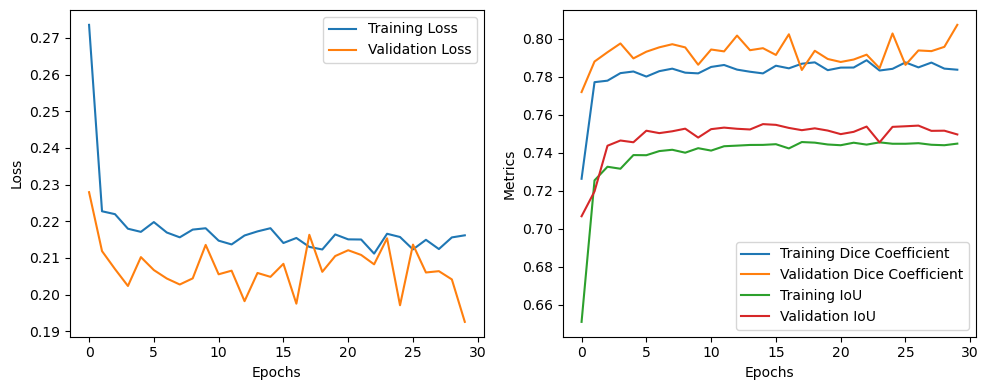

In [13]:
# Plot loss and metrics curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.plot(history.history['iou'], label='Training IoU')
plt.plot(history.history['val_iou'], label='Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# save model weight
model.save('segnetgray.h5')